In [1]:
# Import libraries
import pyspark
import numpy as np
import databricks.koalas as ks
import matplotlib.pyplot as plt

from pyspark import SparkContext, SparkConf

from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.tuning import CrossValidatorModel

from typing import *

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

In [2]:
weather_conditions_df = ks.read_csv('data/weather_description.csv')
humidity_df = ks.read_csv('data/humidity.csv')
pressure_df = ks.read_csv('data/pressure.csv')
temperature_df = ks.read_csv('data/temperature.csv')
city_attributes_df = ks.read_csv('data\city_attributes.csv')
wind_direction_df = ks.read_csv('data/wind_direction.csv')
wind_speed_df = ks.read_csv('data/wind_speed.csv')

humidity_df.columns

columns_to_drop = [  'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia','New York', 'Montreal',
       'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa',
       'Nahariyya', 'Jerusalem']


weather_conditions_df = weather_conditions_df.drop(columns_to_drop, axis=1)
humidity_df = humidity_df.drop(columns_to_drop, axis=1)
pressure_df = pressure_df.drop(columns_to_drop, axis=1)
temperature_df = temperature_df.drop(columns_to_drop, axis=1)
wind_direction_df = wind_direction_df.drop(columns_to_drop, axis=1)
wind_speed_df = wind_speed_df.drop(columns_to_drop, axis=1)


In [5]:
# Melt the DataFrame to convert column names to a single column
weather_conditions_melted = weather_conditions_df.melt(id_vars=['datetime'], var_name='city', value_name='weather_condition')
humidity_mel = humidity_df.melt(id_vars=['datetime'], var_name='city', value_name='humidity')
pressure_mel = pressure_df.melt(id_vars=['datetime'], var_name='city', value_name='pressure')
temperature_mel = temperature_df.melt(id_vars=['datetime'], var_name='city', value_name='temperature')
wind_direction_mel = wind_direction_df.melt(id_vars=['datetime'], var_name='city', value_name='wind_direction')
wind_speed_mel = wind_speed_df.melt(id_vars=['datetime'], var_name='city', value_name='wind_speed')

In [6]:
join_kdf = weather_conditions_melted.join(city_attributes_df.set_index(['City']), on = 'city', how = 'left')  \
        .join(humidity_mel.set_index(['city', 'datetime']), on = ['city', 'datetime'], how = 'outer') \
        .join(pressure_mel.set_index(['city', 'datetime']), on = ['city', 'datetime'], how = 'outer')  \
        .join(temperature_mel.set_index(['city', 'datetime']), on = ['city', 'datetime'],how = 'outer')   \
        .join(wind_direction_mel.set_index(['city', 'datetime']), on = ['city', 'datetime'],how = 'outer')   \
        .join(wind_speed_mel.set_index(['city', 'datetime']), on = ['city', 'datetime'],how = 'outer')


join_kdf.columns

Index(['city', 'datetime', 'weather_condition', 'Country', 'Latitude',
       'Longitude', 'humidity', 'pressure', 'temperature', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [7]:
not_null_weather_measurements_df = join_kdf.dropna()

In [9]:
'''
- Now we join many value in weather into 6 big weathers

a dictionary that goes from the original weather condition name to one among the following:
            - thunderstorm
            - rainy
            - snowy
            - cloudy
            - foggy
            - sunny
'''

'\n- Now we join many value in weather into 6 big weathers\n\na dictionary that goes from the original weather condition name to one among the following:\n            - thunderstorm\n            - rainy\n            - snowy\n            - cloudy\n            - foggy\n            - sunny\n'

In [10]:
# group the same weather

weather_mapping = {
    'sky is clear': 'sunny',
    'overcast clouds': 'cloudy',
    'light rain': 'rainy',
    'broken clouds': 'cloudy',
    'few clouds': 'cloudy',
    'haze': 'foggy',
    'very heavy rain': 'rainy',
    'thunderstorm with rain': 'thunderstorm',
    'smoke': 'foggy',
    'scattered clouds': 'cloudy',
    'proximity shower rain': 'rainy',
    'fog': 'foggy',
    'moderate rain': 'rainy',
    'proximity thunderstorm': 'thunderstorm',
    'light snow': 'snowy',
    'light shower snow': 'snowy',
    'snow': 'snowy',
    'sleet': 'snowy',
    'light shower sleet': 'snowy',
    'mist': 'foggy',
    'proximity thunderstorm': 'thunderstorm',
    'thunderstorm with heavy rain': 'thunderstorm'
}

not_null_weather_measurements_df['weather_condition'] =  \
not_null_weather_measurements_df['weather_condition'].replace(weather_mapping)

# filter out other
valid_values = ['thunderstorm', 'rainy', 'snowy', 'cloudy', 'foggy', 'sunny']
not_null_weather_measurements_df = not_null_weather_measurements_df[not_null_weather_measurements_df['weather_condition'].isin(valid_values)]

In [12]:
value_counts = not_null_weather_measurements_df.groupby('weather_condition').size()

print(value_counts)

weather_condition
rainy           110357
snowy             9927
sunny           374900
cloudy          350190
thunderstorm      6618
foggy           101465
Name: count, dtype: int64


In [13]:

spark_df = not_null_weather_measurements_df.to_spark()

# Specific number to downsample to
specific_number = value_counts.min()

# Downsample each group
def downsample_to_specific_number(df, col_name, count):
    return df.groupBy(col_name).applyInPandas(
        lambda pdf: pdf.sample(n=count, random_state=42) if len(pdf) > count else pdf,
        schema=df.schema
    )

downsampled_spark_df = downsample_to_specific_number(spark_df, 'weather_condition', specific_number)

# Convert back to Koalas DataFrame if needed
balanced_df = downsampled_spark_df.to_koalas()


balanced_df.columns

In [14]:
# value_counters = balanced_df.groupby('weather_condition').size()

# print(value_counters)

In [26]:
# import databricks.koalas as ks
# from pyspark.sql import SparkSession
# from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
# from pyspark.ml.classification import DecisionTreeClassifier
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# from pyspark.sql import SparkSession, functions as F

# spark = SparkSession.builder.appName("KoalasAndSparkML").getOrCreate()
# spark.catalog.clearCache()

In [138]:
import databricks.koalas as ks
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.appName("KoalasAndSparkML").getOrCreate()

spark_df = balanced_df.to_spark()

spark_df = spark_df.orderBy(F.rand())

# Index the weather_condition column
indexer = StringIndexer(inputCol="weather_condition", outputCol="label")
indexed_df_1 = indexer.fit(spark_df)
indexed_df = indexed_df_1.transform(spark_df)


#Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=['humidity', 'pressure','temperature', 'wind_direction', 'wind_speed', 'Longitude','Latitude'],
    outputCol='features'
)
feature_df = assembler.transform(indexed_df)

In [139]:
train_df, test_df = feature_df.randomSplit([0.8, 0.2])

In [140]:
# Train a decision tree classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10 )
dt_model = dt.fit(train_df)

predictions = dt_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy}")

# Show some predictions
#predictions.select('city', 'weather_condition', 'prediction').show()

Test set accuracy = 0.5227443139215197


<AxesSubplot:>

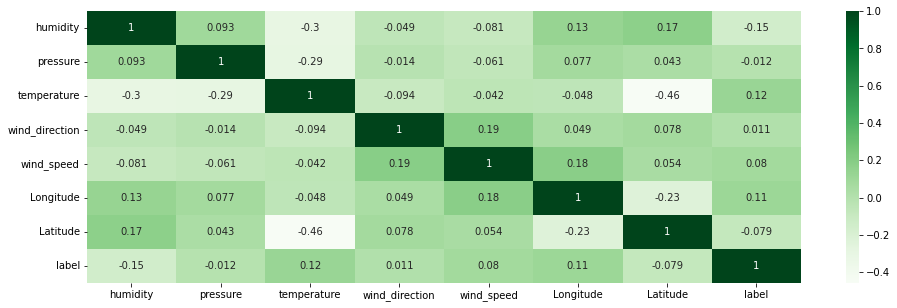

In [20]:
# print out correlation matrix 

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assemblerer = VectorAssembler(inputCols=['humidity', 'pressure','temperature','wind_direction','wind_speed','Longitude','Latitude','label'],\
    outputCol=vector_col)
df_vectorer = assemblerer.transform(indexed_df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vectorer, vector_col)

matrixer = matrix.collect()[0]["pearson({})".format(vector_col)].values


import seaborn as sns 
import matplotlib.pyplot as plt

x_labels = ['humidity', 'pressure','temperature','wind_direction','wind_speed','Longitude','Latitude','label']
y_labels = ['humidity', 'pressure','temperature','wind_direction','wind_speed','Longitude','Latitude','label']

plt.figure(figsize=(16,5))  
sns.heatmap(matrixer.reshape(8,8), 
            xticklabels=x_labels,
            yticklabels=y_labels,  cmap="Greens", annot=True)

In [21]:
'''
We can see:
- Latitude and  Temperature have quite strong correlation
- The same as Temperature/Humidity and Temperature/Pressure and 'Wind_speed'/Wind_direction
- Interestingly, Only: humidity, temperature, Latitude , wind_speed, longtitude

However, we also see that there are big correlation between: Latitude/ temperature, humidity / temperature, longitude / latitude
==> its necessary to use Dimensionally Reduction: PCA, from 5 feature we will down to only 3

'''

"\nWe can see:\n- Latitude and  Temperature have quite strong correlation\n- The same as Temperature/Humidity and Temperature/Pressure and 'Wind_speed'/Wind_direction\n- Interestingly, Only: humidity, temperature, Latitude , wind_speed, longtitude\n\nHowever, we also see that there are big correlation between: Latitude/ temperature, humidity / temperature, longitude / latitude\n==> its necessary to use Dimensionally Reduction: PCA, from 5 feature we will down to only 3\n\n"

In [25]:
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import Pipeline

assembler = VectorAssembler(
    inputCols=['humidity', 'temperature', 'Longitude', 'wind_speed', 'Latitude'],
    outputCol='features'
)
feature_df = assembler.transform(indexed_df)

pca = PCA(k=4, inputCol='features', outputCol='pca_features')
pca_model = pca.fit(feature_df)
pca_df = pca_model.transform(feature_df)



In [41]:
train_dfer, test_dfer = pca_df.randomSplit([0.8, 0.2])

In [ ]:
# Train a decision tree classifier
dter = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10 )
dt_modeler = dt.fit(train_dfer)

predictionser = dt_modeler.transform(test_dfer)

# Evaluate the model
evaluatorer = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracyer = evaluator.evaluate(predictionser)
print(f"Test set accuracy = {accuracyer}")


In [24]:
#turn hyper
dt_1 = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=8)  # Maximum depth of the tree (default is 5)

dt_model_1 = dt.fit(train_df)

predictions_1 = dt_model_1.transform(test_df)

# Evaluate the model
evaluator_1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_1 = evaluator_1.evaluate(predictions_1)
print(f"Test set accuracy = {accuracy_1}")

# Show some predictions
predictions_1.select('city', 'weather_condition', 'prediction').show()

Test set accuracy = 0.5193779004138969
+-----------+-----------------+----------+
|       city|weather_condition|prediction|
+-----------+-----------------+----------+
|Albuquerque|           cloudy|       0.0|
|Albuquerque|           cloudy|       3.0|
|Albuquerque|           cloudy|       4.0|
|Albuquerque|           cloudy|       3.0|
|Albuquerque|           cloudy|       0.0|
|Albuquerque|            sunny|       0.0|
|Albuquerque|           cloudy|       0.0|
|Albuquerque|           cloudy|       0.0|
|Albuquerque|            sunny|       0.0|
|Albuquerque|            rainy|       0.0|
|Albuquerque|     thunderstorm|       5.0|
|Albuquerque|            rainy|       2.0|
|Albuquerque|     thunderstorm|       5.0|
|Albuquerque|           cloudy|       2.0|
|Albuquerque|     thunderstorm|       5.0|
|Albuquerque|     thunderstorm|       5.0|
|Albuquerque|     thunderstorm|       5.0|
|Albuquerque|            sunny|       2.0|
|Albuquerque|            rainy|       1.0|
|Albuquerque|  

In [154]:
# deploy model into real task

DATETIME_COL = 'datetime'
HUMIDITY_COL = 'humidity'
PRESSURE_COL = 'pressure'
TEMPERATURE_COL = 'temperature'
WIND_DIRECTION_COL = 'wind_direction'
WIND_SPEED_COL = 'wind_speed'
LATITUDE_COL = 'Latitude'
LONGITUDE_COL = 'Longitude'
CITY_COL = 'city'
COUNTRY_COL = 'country'
WEATHER_CONDITION_COL = 'weather_condition'

TARGET_VARIABLE_COL = WEATHER_CONDITION_COL
PREDICTED_TARGET_VARIABLE_COL = f'predicted_{TARGET_VARIABLE_COL}'


API_KEY = '****************'

OPENWEATHER_FORECAST_COL = 'openweather_forecast'

API_URL = f'https://api.openweathermap.org/data/2.5/forecast?q=London&appid={API_KEY}'

city_name = 'London'

In [160]:
def all_api_in_one(api_url, city_name):
    
    #API_URL = f'https://api.openweathermap.org/data/2.5/forecast?q=London&appid={API_KEY}'
    
    res = requests.get(api_url).json()
    
    
    coord = res['city']['coord']

    latitude = float(coord['lat'])
    longitude = float(coord['lon'])

    WeatherForecast = Row(DATETIME_COL,
                            HUMIDITY_COL,
                            PRESSURE_COL,
                            TEMPERATURE_COL,
                            WIND_DIRECTION_COL,
                            WIND_SPEED_COL,
                            TARGET_VARIABLE_COL,
                            CITY_COL,
                            LATITUDE_COL,
                            LONGITUDE_COL)

    forecasts = list()

    for forecast in res['list']:
        
        main = forecast['main']
        wind = forecast['wind']
        weather = forecast['weather']

        datetime = forecast['dt_txt']
        
        temperature = float(main['temp'])
        pressure = float(main['pressure'])
        humidity = float(main['humidity'])
        wind_speed = float(wind['speed'])
        wind_direction = float(wind['deg'])

        weather_condition = weather[0]['main']
        
        forecast_row = WeatherForecast(datetime,
                                        humidity,
                                        pressure,
                                        temperature,
                                        wind_direction,
                                        wind_speed,
                                        weather_condition,
                                        city_name,
                                        latitude,
                                        longitude)

        forecasts.append(forecast_row)
        
    api_dataframe = spark.createDataFrame(forecasts).to_koalas()
    
    weather_mapping = {
    'sky is clear': 'sunny',
    'overcast clouds': 'cloudy',
    'light rain': 'rainy',
    'broken clouds': 'cloudy',
    'few clouds': 'cloudy',
    'haze': 'foggy',
    'very heavy rain': 'rainy',
    'thunderstorm with rain': 'thunderstorm',
    'smoke': 'foggy',
    'scattered clouds': 'cloudy',
    'proximity shower rain': 'rainy',
    'fog': 'foggy',
    'moderate rain': 'rainy',
    'proximity thunderstorm': 'thunderstorm',
    'light snow': 'snowy',
    'light shower snow': 'snowy',
    'snow': 'snowy',
    'sleet': 'snowy',
    'light shower sleet': 'snowy',
    'mist': 'foggy',
    'proximity thunderstorm': 'thunderstorm',
    'thunderstorm with heavy rain': 'thunderstorm',
    'Rain': 'rainy'
    }

    api_dataframe['weather_condition'] =  \
    api_dataframe['weather_condition'].replace(weather_mapping)

    # filter out other
    valid_values = ['thunderstorm', 'rainy', 'snowy', 'cloudy', 'foggy', 'sunny']
    api_dataframe = api_dataframe[api_dataframe['weather_condition'].isin(valid_values)]
    
    
    indexed_df_api = indexed_df_1.transform(api_dataframe.to_spark())


    assembler_api = VectorAssembler(
        inputCols=['humidity', 'pressure','temperature', 'wind_direction', 'wind_speed', 'Longitude','Latitude'],
        outputCol='features'
    )
    feature_df_api = assembler_api.transform(indexed_df_api)
    
    predictions_api = dt_model.transform(feature_df_api)

    evaluator_api = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy_api = evaluator_api.evaluate(predictions_api)
    print(f"Test set accuracy = {accuracy}")

    predictions_api.select('city', 'weather_condition', 'prediction').show()
    

In [161]:
import time

polling_interval = 60  # 1 minute

while True:
    # Fetch data from the API
    data = all_api_in_one(API_URL, city_name)
    
    time.sleep(polling_interval)

Test set accuracy = 0.5227443139215197
+------+-----------------+----------+
|  city|weather_condition|prediction|
+------+-----------------+----------+
|London|            rainy|       5.0|
|London|            rainy|       1.0|
|London|            rainy|       5.0|
|London|            rainy|       2.0|
|London|            rainy|       2.0|
|London|            rainy|       5.0|
|London|            rainy|       0.0|
|London|            rainy|       5.0|
|London|            rainy|       1.0|
|London|            rainy|       2.0|
|London|            rainy|       1.0|
|London|            rainy|       5.0|
|London|            rainy|       5.0|
|London|            rainy|       1.0|
|London|            rainy|       0.0|
|London|            rainy|       5.0|
|London|            rainy|       5.0|
|London|            rainy|       5.0|
|London|            rainy|       5.0|
|London|            rainy|       5.0|
+------+-----------------+----------+
only showing top 20 rows



KeyboardInterrupt: 